Filtering, imputing and summarizing our data set in various ways and so preparing it for distinct ways of modeling.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from bsmcalls import individuals
from bsmcalls import preprocessing
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import re

## Import and filter

In [2]:
calls, clin = individuals.get_data(merge=False, cleancalls=False, cols2drop=[])

Number of missing values

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3411 entries, ('CMC_MSSM_027', 'NeuN_pl', '1', 11973569, 'C/T') to ('CMC_MSSM_331', 'muscle', 17, 29109599, 'T/G')
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   REF                   3411 non-null   category
 1   ALT                   3411 non-null   category
 2   QUAL                  3411 non-null   float64 
 3   FILTER/PASS           3411 non-null   category
 4   FILTER/HC             3411 non-null   category
 5   FILTER/EXT            3411 non-null   category
 6   AC                    3411 non-null   int64   
 7   AF                    3411 non-null   float64 
 8   AN                    3411 non-null   int64   
 9   BaseQRankSum          3411 non-null   float64 
 10  DP                    3411 non-null   int64   
 11  DS                    0 non-null      float64 
 12  END                   0 non-null      float64 
 13  ExcessHet        

In [4]:
clin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, CMC_MSSM_305 to CMC_MSSM_130
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Institution              86 non-null     category
 1   Reported Gender          86 non-null     category
 2   Sex                      86 non-null     category
 3   Ethnicity                86 non-null     category
 4   ageOfDeath               86 non-null     float64 
 5   Brain Weight (in grams)  85 non-null     float64 
 6   PMI (in hours)           86 non-null     float64 
 7   Dx                       86 non-null     category
 8   Year of Autopsy          86 non-null     float64 
 9   Benzodiazepines          86 non-null     category
 10  Anticonvulsants          86 non-null     category
 11  AntipsychTyp             86 non-null     category
 12  AntipsychAtyp            86 non-null     category
 13  Antidepress              86 non-null     category
 

Let's look for degenerate variables (those with zero or nearly zero variance)

In [5]:
calls.var().dropna().sort_values()

POSITIVE_TRAIN_SITE         0.000000
AN                          0.000000
NEGATIVE_TRAIN_SITE         0.000000
MQ                          0.000125
MLEAF                       0.007985
AF                          0.008280
MQRankSum                   0.020116
evolConstrain               0.042054
SOR                         0.345994
SiPhyBranchLen              0.559698
ReadPosRankSum              1.250266
SiPhyLOD                    2.162401
GWASpval                    5.493177
BaseQRankSum                6.607158
QD                         11.824981
FS                         16.177867
szdbCNVcount               17.656994
MLEAC                      19.961826
AC                         20.698950
VQSLOD                     28.677638
DP                       8913.871265
QUAL                   781087.582579
dtype: float64

`AN` has zero sample variance.  `MQ` and `MQRankSum` have nearly zero sample variance.  Remove them!

## Filtered, merged data

In [6]:
calls1, clin1 = individuals.get_data(merge=False, cleancalls=False, cols2drop=[])

## Correlations between call based variables

First turn factors to dummy variables and then calculate the correlation matrix.  For simplicity we treat `object` type variables as factors and not binary $\{0, 1\}$ valued categorical variables.

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f809b033690>)

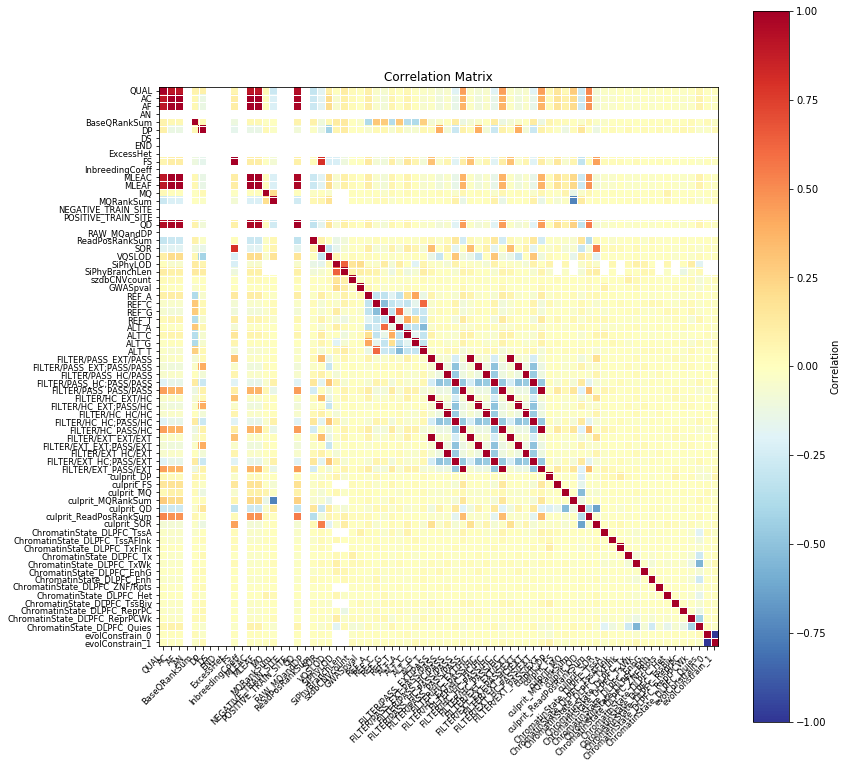

In [7]:
calls1num = preprocessing.dummify_df(calls1)
def corrmatplot(dfnum):
    corrmat = dfnum.corr()
    fig, ax = plt.subplots(figsize=(12,12))
    sm.graphics.plot_corr(corrmat, ax=ax, xnames=dfnum.columns, ynames=dfnum.columns)
    cb = plt.colorbar(ax.get_images()[0])
    cb.set_label('Correlation')
    return((fig, ax))

corrmatplot(calls1num)

## Correlations between call based and clinical variables

Here we use `bsmcalls.individuals.get_data` with `cleancalls=True`, which removes the following redundant and degenerate variables from the calls (compare with plot above).

In [8]:
redundant_vars = ['FILTER/HC', 'FILTER/EXT', 'QUAL', 'AC', 'MLEAC', 'MLEAF', 'QD']
degenerate_vars = ['AN', 'MQ', 'MQRankSum']

In [9]:
calls2 = individuals.get_data(merge=True, cleancalls=True, cols2drop=[])

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f809b1589d0>)

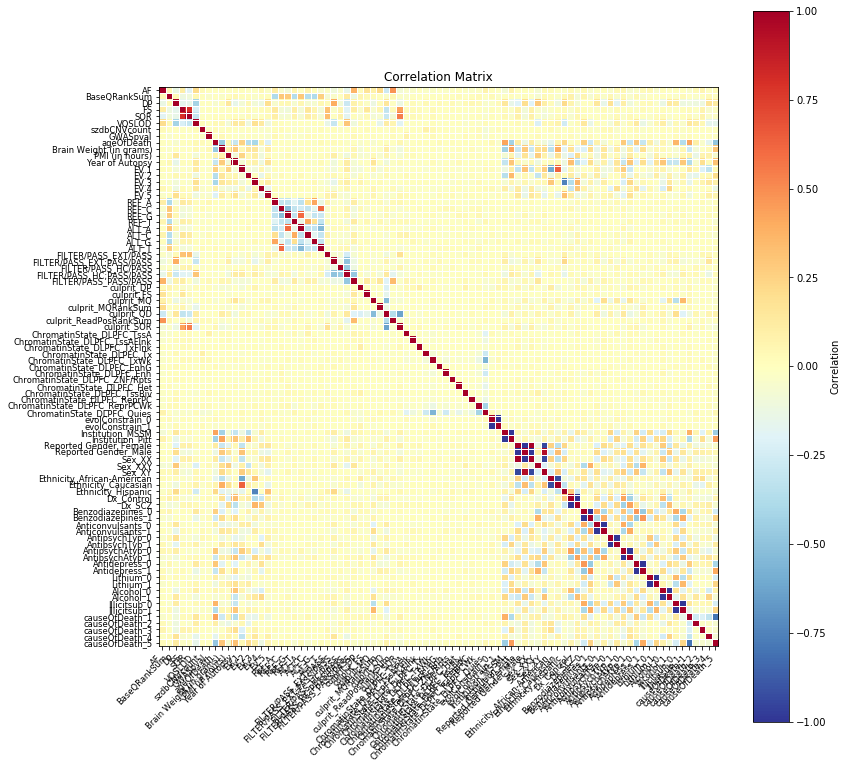

In [10]:
calls2num = preprocessing.dummify_df(calls2)
corrmatplot(calls2num)

The only strong correlation that stands out is between *Sex* and *Reported Gender*.  Removing *Sex* has been automated by adding `cols2drop=['Sex']` default argument to `bsmcalls.individuals.get_data`

In [11]:
%connect_info

{
  "shell_port": 60411,
  "iopub_port": 44551,
  "stdin_port": 40285,
  "control_port": 60271,
  "hb_port": 58277,
  "ip": "127.0.0.1",
  "key": "171b445a-fd21972583fc359b1e407578",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b0143a18-9635-43f1-bdbb-7ed45421f6c9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
